# Quantifying epistasis with $\Delta\varepsilon_{AI}$

© 2018 The Authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [1]:
import sys
import numpy as np
import pandas as pd
import pystan
import altair as alt
sys.path.insert(0, '../../')
import mut.thermo
import mut.stats
import mut.bayes
import mut.viz
pboc = mut.viz.altair_config()
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


RendererRegistry.enable('notebook')

In this notebook, we will examine the contribution of inducer domain mutations to the allosteric energetic parameter $\Delta\varepsilon_{AI}$

## The Problem

Thus far in our analysis, we have seen that some inducer domain mutations (namely, Q294K and Q294R) alter the affinity for the DNA, leading to a larger than expected leakiness in gene expression. This effect is the most apparent when paired with thte O2 operator. This finding is seemingly at odds with that reported in [Daber et al. 2011]() where these particular mutants influecence *only* the inducer binding affinities. However, the experiments performed in [Daber et al. 2011]() were slightly different in that the mutant LacI was expressed from a plasmid and expression of a GFP reporter was regulated by an O1 sequence, which has a stronger binding energy. These differences led us to perform *our* experiments in an O1 operator strain. These experiments showed virtually no difference in the leakiness! We hypothesize that the mtuations in teh inducer binding domain also alter the energetic difference beteween the active and inactive state of the repressor. In the coming sections, we will estimate the most likely value of the allosteric energy difference $\Delta\varepsilon_{AI}$ for all inducer mutants for one operator binding energy and then use that information to predict the other operators. We will conclude with seeing if these corrections can allow for accurate prediction of all pairwise double mutants of DNA and inducer binding mutations.  

To be clear, our hypothesis is that mutations in the inducer binding domain are **not** restricted to altering only the $K_A$ and $K_I$. t is also possilbe that these mutations alter the allosteric energy difference $\Delta\varepsilon_{AI}$ and/or the DNA binding energy $\Delta\varepsilon_{RA}$. We are assuming that alterations to the DNA binding affinity are much less likely than alterations to the allosteric energy difference. Mathematically, we can state that the fold-change in gene expression is given by

$$
\text{fold-change} = \left( 1 + {\left(1 + {c \over \mathbf{K_A}}\right)^n \over \left(1 + {c \over \mathbf{K_A}}\right)^n + e^{-\beta\mathbf{\Delta\varepsilon_{AI}}}\left(1 + {c \over \mathbf{K_I}}\right)^n} {R \over N_{NS}}e^{-\beta\Delta\varepsilon_{RA}}\right)^{-1},
$$

where the bold symbols indicate those that can be altered by mutations to the inducer binding domain. As we learned from [Razo-Mejia et al. 2018](), there is complete degeneracy between the parameters $K_A$, $K_I$, and $\Delta\varepsilon_{AI}$ and it is impossible to fit them given only an induction profile. 

However, by examining the leakiness of the system, we can determine the most-likely value for the allosteric energy difference $\Delta\varepsilon_{AI}$. The leakiness is given by

$$
\text{leakiness} = \left(1 + {1 \over 1 + e^{-\beta\Delta\varepsilon_{AI}}}{R \over N_{NS}}e^{-\beta\Delta\varepsilon_{RA}}\right)^{-1}.
$$

So long as we know the values for $\Delta\varepsilon_{RA}$, $R$, and $N_{NS}$, we can determine the most-likely value for $\Delta\varepsilon_{AI}$.

Experimentally, we have measured IPTG titration curves for all DNA single mutants in O1, O2, and O3. In the following sections, we will use the measurement at $c = 0$ to determine $\Delta\varepsilon_{AI}$ for that particular mutant. Using this value, we will then fit the most-likely values for $K_A$ and $K_I$ based on the remaining induction curves. With all of these parameters in hand, we can then predict the behavior of the single inducer mutants in other operators as well as the entire induction profile of the double mutants.  

## Fitting $\Delta\varepsilon_{AI}$ 

To begin, we will load the most recent data and perform some basic filtering. We will restrict the fitting data to those measured with an O2 ($-13.9\, k_BT$) operator.  

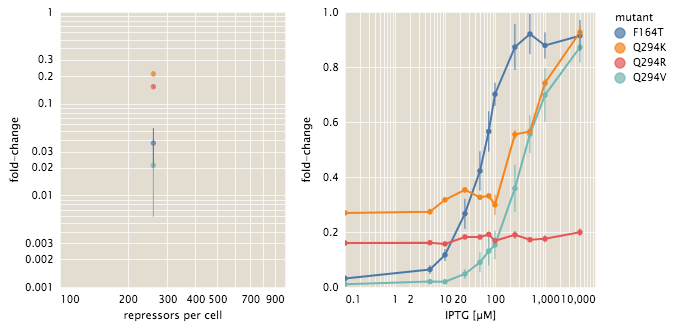

In [2]:
# Load the data
data = pd.read_csv('../../data/csv/compiled_data.csv')

# Isolate inducer mutants and operator O2
ind = data[data['class'] == 'IND'].copy()
O2 = ind[ind['operator'] == 'O2'].copy()

# Isolate the leakiness data. 
leak = O2[O2['IPTGuM'] == 0].copy()

# Plot the data for the leakiness 
leak_base = alt.Chart(leak, width=225, height=275).transform_aggregate(
    R='mean(repressors):Q', mean_fc='mean(fold_change):Q', 
    sem='stderr(fold_change):Q', groupby=['mutant']).transform_calculate(
    lower='datum.mean_fc - datum.sem',
    upper='datum.mean_fc + datum.sem')
leak_points = leak_base.mark_circle().encode(
    x=alt.X('R:Q', title='repressors per cell', scale={'type':'log'}),
    y=alt.Y('mean_fc:Q', title='fold-change', scale={'type':'log'}),
    color='mutant')
leak_errs = leak_base.mark_rule().encode(
    x=alt.X('R:Q', title='repressors per cell', scale={'type':'log'}),
    y=alt.Y('lower:Q', title='fold-change', scale={'type':'log'}),
    y2='upper:Q', color='mutant')
leak_plot = (leak_points + leak_errs).interactive()


# Plot complete induction curves.
titration_base = alt.Chart(O2[O2['IPTGuM'] != 0], width=250, height=275).transform_aggregate(
    mean_fc='mean(fold_change):Q', sem='stderr(fold_change):Q',
    groupby=['mutant', 'IPTGuM']).transform_calculate(
    lower='datum.mean_fc - datum.sem',
    upper='datum.mean_fc + datum.sem')
titration_points = titration_base.mark_line(point=True).encode(
    x=alt.X('IPTGuM:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('mean_fc:Q', title='fold-change'), color='mutant')
titration_errs = titration_base.mark_rule().encode(
    x=alt.X('IPTGuM:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('lower:Q', title='fold-change'),
    y2='upper:Q', color='mutant')
titration_plot = (titration_points + titration_errs).interactive()

# Combine the facets
alt.hconcat(leak_plot, titration_plot, config=pboc)

Using the leakiness data (leftmost plot), we can fit the allosteric energy $\Delta\varepsilon_{AI}$. Using the titration data (rightmost plot) and given the allosteric energy, we can fit the inducer binding constants $K_A$ and $K_I$. To perform this inference, we can use Markov chain Monte Carlo (MCMC) to sample the posterior distribution directly. Sparing the details, this model has been written as a [`Stan` model](../stan/hierarchical_inducer_fitting.stan). Below, we load the model and sample

In [3]:
# Load the stan model.
inducer_model = pystan.StanModel('../stan/hierarchical_inducer_fitting.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6089539d427f5e8adcb5be27baf3b10d NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmptxt99hll/stanfit4anon_model_6089539d427f5e8adcb5be27baf3b10d_8023856965463958605.cpp:640:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1818:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmptxt99hll/stanfit4anon_model_6089539d427f5e8adcb5be27baf3b10d_8023856965463958605.cpp:9214:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [ ]:
# Define the wild-type DNA binding energies. 
op_dict = {'O1':-15.3, 'O2':-13.9, 'O3':-9.7}

# Assemble the mutant identities for efficient sampling. 
ind_idx = {m: i+1 for i, m in enumerate(leak['mutant'].unique())}
idx_key = {i+1:m for i, m in enumerate(leak['mutant'].unique())}
for m in leak['mutant'].unique():
    O2.loc[O2['mutant'] == m, 'idx']= ind_idx[m]
    leak.loc[leak['mutant'] == m, 'idx']= ind_idx[m]

# Assemble the data dictionary for sampling. 
data_dict = {'J':len(leak['mutant'].unique()), 'N_leak':len(leak), 'N':len(O2),
            'idx_leak':leak['idx'].values.astype(int), 
             'idx':O2['idx'].values.astype(int), 'R':260, 'Nns':4.6E6,
            'epR':op_dict['O2'], 'n_sites':2, 'c':O2['IPTGuM'], 
            'fc_leak':leak['fold_change'], 'fc':O2['fold_change']}

# Sample the model and convert to a data frame. 
print('beginning sampling....')
sampling = inducer_model.sampling(data_dict, iter=10000, chains=4)
sampling_df = mut.bayes.chains_to_dataframe(sampling)
print('....finished!')

# Rename the columns. 
rename = {}
for p in sampling_df.keys():
    if '.' in p:
        param, key = p.split('.')
        rename[p] = '{}.{}'.format(param, idx_key[key])
sampling_df.rename(columns=rename, inplace=True)

# Convert dataframe to longform tidy
tidy_df = mut.bayes.longform_mcmc_df(sampling_df)

# Compute the statistics. 
inducer_stats = mut.stats.compute_statistics(sampling_df)

With everything sampled, we can look at the marginalized distributions of the parameters.

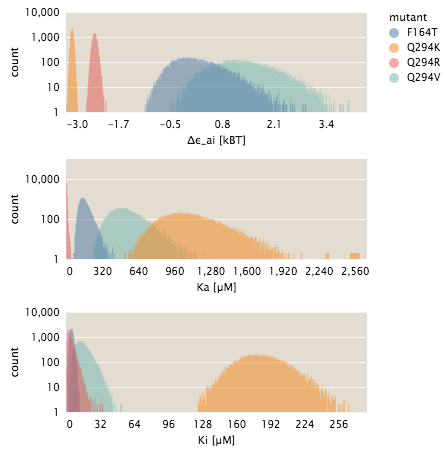

In [248]:
# Make a chart of all distributions. 
grouped = tidy_df.groupby('parameter')
parameters = {'ep_ai': 'k_BT', 'ka':'µM', 'ki':'µM'}
titles = {'ep_ai':'Δε_ai [kBT]', 'ka': 'Ka [µM]', 'ki':'Ki [µM]'}
charts = []
for g, d in grouped: 
    if g in parameters.keys():
        _chart = alt.Chart(d, height=100, width=300).mark_area(
            interpolate='step', opacity=0.5).encode(
        x=alt.X('value', title=titles[g], bin=alt.Bin(maxbins=1000)),
        y=alt.Y('count(value)', title='count', stack=None, scale={'type':'log'}, 
          axis=alt.Axis(tickCount=3)), color='mutant')
        charts.append(_chart)
        
# Vertcally concat the plots
alt.vconcat(charts[0], charts[1], charts[2], config=pboc)

All of the marginalized distributions look well behaved. Interesting, it seems like all of the inducer mutations modify the allosteric energy difference. Another interesting quantity is the ratio of $K_A$ to $K_I$ for the Q294R mutant, which is close to 1.0. This indicates that ther repressor binds the repressor equally tightly (~2 µM)! Using the modes of these distributions, we can see how well the fits agree with the data. First, we'll compute the best fit and appropriate credible regions for each mutant. Since we will be doing this for several other operators, we will write this as a function. 

In [282]:
def compute_fits(mutants, operators, statistics, samples, repressors=[260]):
    # Define the ranges of parameter values.  
    rep_range = np.logspace(0, 4, 500)
    c_range = np.logspace(-2, 4, 500)
    
    # Instantiate the empty DataFrame.
    fit_df = []
    
    # Iterate through each mutant.
    for i, m in enumerate(mutants):
        for k, op in enumerate(operators):
            # Extract the most-likely parameter values.
            ep_ai_mode = statistics[statistics['parameter']=='ep_ai.{}'.format(m)]['mode'].values[0]
            ka_mode = statistics[statistics['parameter']=='ka.{}'.format(m)]['mode'].values[0]
            ki_mode = statistics[statistics['parameter']=='ki.{}'.format(m)]['mode'].values[0]
            
            # Extract the chains. 
            ep_ai_chain = samples['ep_ai.{}'.format(m)]
            ka_chain = samples['ka.{}'.format(m)]
            ki_chain = samples['ki.{}'.format(m)]
            
            # Compute the best-fit for the leakiness.
            best_fit = mut.thermo.SimpleRepression(R=rep_range, ep_r=operators[op], effector_conc=0, 
                                                  ka=ka_mode, ki=ki_mode, ep_ai=ep_ai_mode).fold_change()
        
            # Compute the credible regions.
            cred_region = np.zeros((2, len(rep_range)))
            for j, r in enumerate(rep_range):
                theo_fc = mut.thermo.SimpleRepression(R=r, ep_r=operators[op], effector_conc=0,
                                            ka=ka_chain, ki=ki_chain, ep_ai=ep_ai_chain).fold_change()
                cred_region[:, j] = mut.stats.compute_hpd(theo_fc, mass_frac=0.95)
                
            # Assemble and append the data frame 
            _df = pd.DataFrame(np.array([rep_range, best_fit, cred_region[0, :], cred_region[1, :]]).T, 
                              columns=['repressors', 'mode', 'ci_min', 'ci_max']) 
            _df['mutant'] = m
            _df['IPTGuM'] = 0
            _df['operator'] = op
            _df['binding_energy'] = operators[op]
            fit_df.append(_df)
                                 
            # Compute the best-fit for the induction curve. 
            for z, R in enumerate(repressors):
                best_fit = mut.thermo.SimpleRepression(R, ep_r=operators[op], effector_conc=c_range,
                                                  ka=ka_mode, ki=ki_mode, ep_ai=ep_ai_mode).fold_change()
                # Compute the credible region. 
                cred_region = np.zeros((2, len(c_range)))
                for j, c in enumerate(c_range):
                    theo_fc = mut.thermo.SimpleRepression(R, ep_r=operators[op], effector_conc=c,
                                            ka=ka_chain, ki=ki_chain, ep_ai=ep_ai_chain).fold_change()
                    cred_region[:, j] = mut.stats.compute_hpd(theo_fc, mass_frac=0.95)
        
                 # Assemble and append the data frame 
                _df = pd.DataFrame(np.array([c_range, best_fit, cred_region[0, :], cred_region[1, :]]).T, 
                              columns=['IPTGuM', 'mode', 'ci_min', 'ci_max']) 
                _df['mutant'] = m
                _df['repressors'] = R
                _df['operator'] = op
                _df['binding_energy'] = operators[op]
                fit_df.append(_df)   
            
    # Concatenate all dataframes into a single fit. 
    fit_df = pd.concat(fit_df, sort=False)
    return fit_df

In [283]:
# Call the function on our data. 
fit_df = compute_fits(O2['mutant'].unique(), op_dict, inducer_stats, sampling_df)

... and generate the plots!

In [294]:
def plot_fits(fit_df, data_df, operator):
    # Plot the leakiness and titration curve fits. 
    leak_fit_base = alt.Chart(fit_df[(fit_df['IPTGuM']==0) & (fit_df['operator'] == operator)], 
                              width=225, height=225)
    leak_fit_mode = leak_fit_base.mark_line().encode(
        x=alt.X('repressors', title='repressors per cell', scale={'type':'log'}),
        y=alt.Y('mode', title='fold-change', scale={'type':'log'}), color='mutant')
    leak_fit_ci = leak_fit_base.mark_area(opacity=0.4).encode(
        x=alt.X('repressors', title='repressors per cell', scale={'type':'log'}),
        y=alt.Y('ci_min', title='fold-change', scale={'type':'log'}),
        y2='ci_max', color='mutant')
    leak_fit = leak_fit_mode + leak_fit_ci
    
    titration_fit_base = alt.Chart(fit_df[(fit_df['IPTGuM'] != 0) & (fit_df['operator'] == operator)], 
                                   width=225, height=225)
    titration_fit_mode = titration_fit_base.mark_line().encode(
        x=alt.X('IPTGuM', title='IPTG [µM]', scale={'type':'log'}),
        y=alt.Y('mode', title='fold-change'), color='mutant')
    titration_fit_ci = titration_fit_base.mark_area(opacity=0.4).encode(
        x=alt.X('IPTGuM', title='IPTG [µM]', scale={'type':'log'}),
        y=alt.Y('ci_min', title='fold-change'),
        y2='ci_max', color='mutant')
    
    titration_fit = titration_fit_mode + titration_fit_ci
    
    # Plot the data for the leakiness 
    leak_base = alt.Chart(data_df[(data_df['IPTGuM']==0) & (data['operator']==operator)]
                          , width=225, height=275).transform_aggregate(
        R='mean(repressors):Q', mean_fc='mean(fold_change):Q', 
        sem='stderr(fold_change):Q', groupby=['mutant']).transform_calculate(
        lower='datum.mean_fc - datum.sem',
        upper='datum.mean_fc + datum.sem')
    leak_points = leak_base.mark_circle().encode(
        x=alt.X('R:Q', title='repressors per cell', scale={'type':'log'}),
        y=alt.Y('mean_fc:Q', title='fold-change', scale={'type':'log'}),
        color='mutant')
    leak_errs = leak_base.mark_rule().encode(
        x=alt.X('R:Q', title='repressors per cell', scale={'type':'log'}),
        y=alt.Y('lower:Q', title='fold-change', scale={'type':'log'}),
        y2='upper:Q', color='mutant')
    leak_plot = (leak_points + leak_errs).interactive()
    
    
    # Plot complete induction curves.
    titration_base = alt.Chart(data_df[(data_df['IPTGuM'] != 0) & (data_df['operator']==operator)],
                               width=250, height=275).transform_aggregate(
        mean_fc='mean(fold_change):Q', sem='stderr(fold_change):Q',
        groupby=['mutant', 'IPTGuM']).transform_calculate(
        lower='datum.mean_fc - datum.sem',
        upper='datum.mean_fc + datum.sem')
    titration_points = titration_base.mark_circle().encode(
        x=alt.X('IPTGuM:Q', title='IPTG [µM]', scale={'type':'log'}),
        y=alt.Y('mean_fc:Q', title='fold-change'), color='mutant')
    titration_errs = titration_base.mark_rule().encode(
        x=alt.X('IPTGuM:Q', title='IPTG [µM]', scale={'type':'log'}),
        y=alt.Y('lower:Q', title='fold-change'),
        y2='upper:Q', color='mutant')
    titration_plot = (titration_points + titration_errs).interactive()
    
    # Combine the facets
    return alt.hconcat(leak_plot + leak_fit, titration_plot + titration_fit, config=pboc)

O2 fits


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


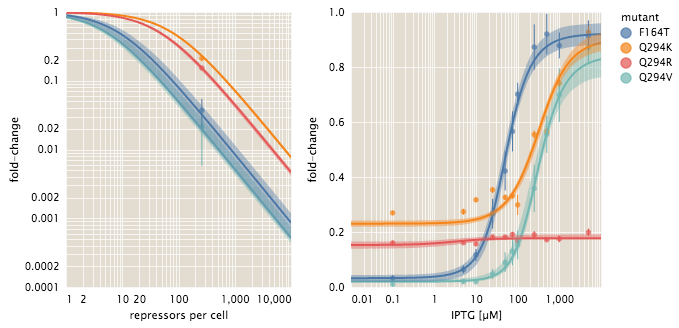

In [306]:
print('O2 fits')
plot_fits(fit_df, ind, operator='O2') 

O1 predictions


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


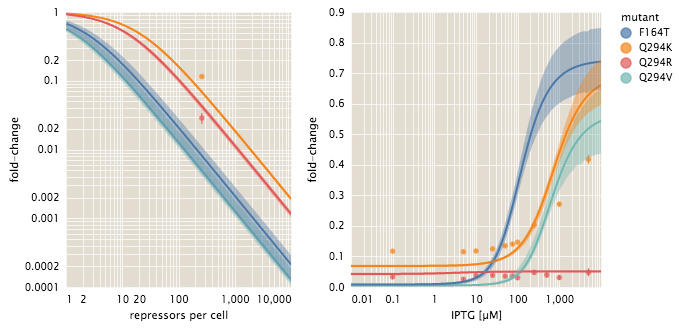

In [307]:
print('O1 predictions')
plot_fits(fit_df, ind, operator='O1') 

O3 predictions


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


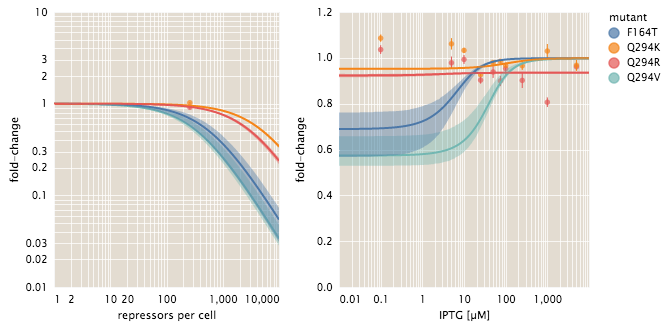

In [308]:
print('O3 predictions')
plot_fits(fit_df, ind, operator='O3') 

As expected, the fits to the O2 data are very nice. The predictions, on the other hand, are a mixed bag. There appear to be some pretty large fluctuations in the measured fold-change for the O3 mutants, which is likely due to counting single-day replicates as true biological replicates. For O3, the predictions seem to do a prety good job in predicting that the response is flat and fixed (more or less) right at $1$. For O1, the prediction for Q294R is very good and is pretty bad for Q294K. WE are off both in leakiness and the gneral titration curve. Obviously, there is a lot of food for thought here. 